<a href="https://colab.research.google.com/github/jaswu51/GraphEmbeddings/blob/main/GraphEmbeddings_RGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node-level embedding via Relational Graph Convolutional Network (RGCN) under node classification virtual tasks

We use stellagraph. The reason is that it offers both the **edge type** and **edge weight** choice, while RGCN algorithm in other packages like PyG or DGL doesn't offer such.

This node-level embedding is for the later usage of the **discriminator network**.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 4.9 MB/s 
     |████████████████████████████████| 500 kB 48.6 MB/s 
     |████████████████████████████████| 121 kB 53.3 MB/s 
     |████████████████████████████████| 1.6 MB 51.7 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 41 kB 520 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [ ]:
node_feature_index = pd.DataFrame(
    {"node_f1": [1, 2, 3, 4], "node_f2": [-0.3, 0.23, 1.0, -1.5], "node_f3": [-0.2, 0.3, 0.0, -0.5], "node_f4": [0.2, 1.3, 1.0, -4], "node_f5": [2, 3.3, 2.0, 4.5]}, index=[1, 2, 3, 4]
)
node_feature_index

,node_f1,node_f2,node_f3,node_f4,node_f5
1,1,-0.30,-0.2,0.2,2.0
2,2,0.23,0.3,1.3,3.3
3,3,1.00,0.0,1.0,2.0
4,4,-1.50,-0.5,-4.0,4.5


In [ ]:
node_label= pd.DataFrame(
    {"label": [1, 0, 2, 1]}, index=[1, 2, 3, 4]
)
node_label

,label
1,1
2,0
3,2
4,1


In [ ]:
edge_source_target_weight_features = pd.DataFrame(
    {
        "source": [1,2,3,4,1],
        "target": [2,3,4,1,3],
        "weight": [1.0, 0.2, 3.4, 5.67, 1.0],
        "A": [-1, 2, -3, 4, -5],
        "B": [0.4, 0.1, 0.9, 0, 0.9],
        "C": [12, 34, 56, 78, 90],
    }
)
edge_source_target_weight_features

,source,target,weight,A,B,C
0,1,2,1.00,-1,0.4,12
1,2,3,0.20,2,0.1,34
2,3,4,3.40,-3,0.9,56
3,4,1,5.67,4,0.0,78
4,1,3,1.00,-5,0.9,90


In [ ]:
G = StellarGraph(
    {"corner": node_feature_index}, {"line": edge_source_target_weight_features}
)

G.info()

'StellarGraph: Undirected multigraph\n Nodes: 4, Edges: 5\n\n Node types:\n  corner: [4]\n    Features: float32 vector, length 5\n    Edge types: corner-line->corner\n\n Edge types:\n    corner-line->corner: [5]\n        Weights: range=[0.2, 5.67], mean=2.254, std=2.25534\n        Features: float32 vector, length 3'

In [ ]:
train_targets, test_targets = model_selection.train_test_split(
    node_label, train_size=0.8, test_size=None
)
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_targets.index, targets=train_targets)
test_gen = generator.flow(test_targets.index, targets=test_targets)

## Train the RGCN as the node label prediction task

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 59ms/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 60ms/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 49ms/step - loss: 0.0000e+00 - acc: 0.3333 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 8/20
1/1 [===========================

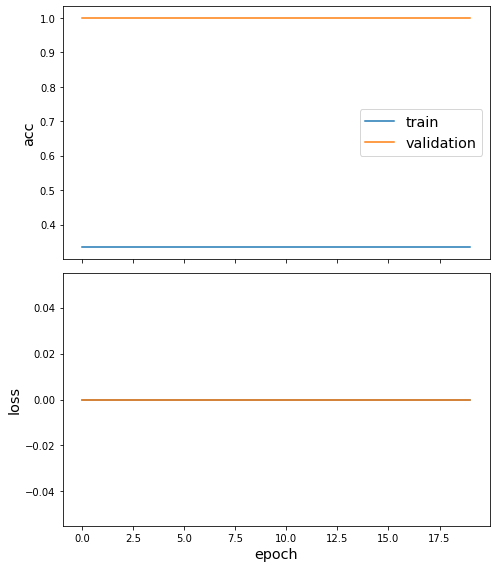

In [ ]:
rgcn = RGCN(
    layer_sizes=[5, 3],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=20,
    dropout=0.5,
)
x_in, x_out = rgcn.in_out_tensors()

predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)
history = model.fit(train_gen, validation_data=test_gen, epochs=20)
sg.utils.plot_history(history)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

## Obtain Node embeddings from the layer[-2] before softmax classification

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# get embeddings for all people nodes
all_gen = generator.flow(node_label.index, targets=node_label)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict(all_gen)

1/1 [==============================] - 0s 357ms/step


## visualize the embedding results

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


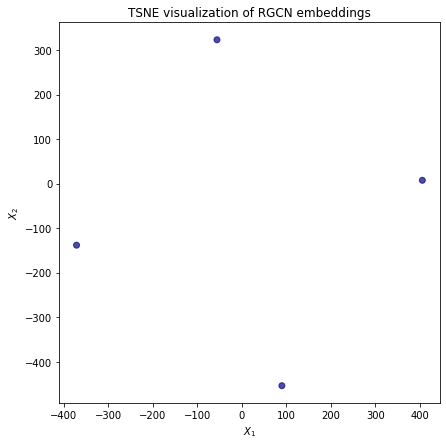

In [ ]:
X = emb.squeeze(0)
y = node_label.idxmax(axis="columns").astype("category")

if X.shape[1] > 2:
    transform = TSNE

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_label.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_label.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of RGCN embeddings".format(transform.__name__)
)
plt.show()

In [ ]:
X

array([[0.        , 0.8773173 , 0.44308147],
       [0.        , 1.7091208 , 1.6780554 ],
       [0.        , 0.68275815, 0.29092398],
       [0.        , 2.3694568 , 0.        ]], dtype=float32)